In [1]:
import pandas as pd

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
merged_data = pd.merge(transactions, customers, on='CustomerID')

In [2]:
total_spend = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spend.columns = ['CustomerID', 'TotalSpend']

In [3]:
num_transactions = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
num_transactions.columns = ['CustomerID', 'NumTransactions']

In [4]:
avg_transaction_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.columns = ['CustomerID', 'AvgTransactionValue']

In [5]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['DaysSinceSignup'] = (pd.Timestamp.now() - customers['SignupDate']).dt.days

In [13]:
print(merged_data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')


In [15]:
category_pivot = merged_data.pivot_table(index='CustomerID',
                                        columns='ProductID',  # Using 'ProductID' as a proxy for category
                                        values='TransactionID',
                                        aggfunc='count',
                                        fill_value=0)



In [16]:
region_pivot = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'], prefix='Region')


In [17]:
customer_features = pd.merge(total_spend, num_transactions, on='CustomerID')
customer_features = pd.merge(customer_features, avg_transaction_value, on='CustomerID')
customer_features = pd.merge(customer_features, category_pivot, on='CustomerID')
customer_features = pd.merge(customer_features, region_pivot, on='CustomerID')
customer_features = pd.merge(customer_features, customers[['CustomerID', 'DaysSinceSignup']], on='CustomerID')

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))
scaled_features = pd.DataFrame(scaled_features, columns=customer_features.columns[1:])
scaled_features['CustomerID'] = customer_features['CustomerID']

In [19]:
from sklearn.cluster import KMeans

In [21]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features.drop(columns=['CustomerID']))
customer_features['Cluster'] = kmeans.labels_

In [22]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_features.drop(columns=['CustomerID']), kmeans.labels_)
print(f"DB Index: {db_index:.4f}")

DB Index: 2.7728


Silhouette score for k=2: 0.077
Silhouette score for k=3: 0.062
Silhouette score for k=4: 0.069
Silhouette score for k=5: 0.096
Silhouette score for k=6: 0.074
Silhouette score for k=7: 0.044
Silhouette score for k=8: 0.076
Silhouette score for k=9: 0.076
Silhouette score for k=10: 0.067


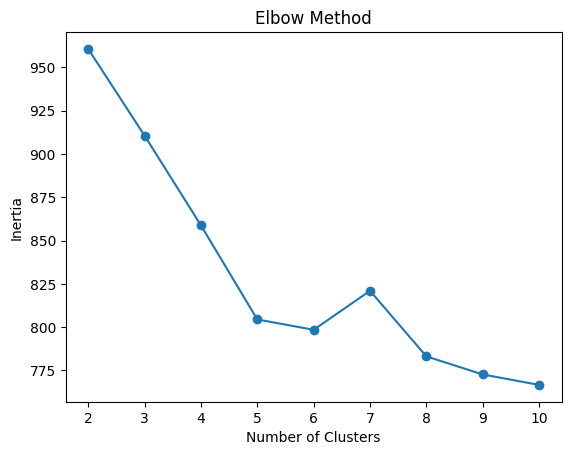

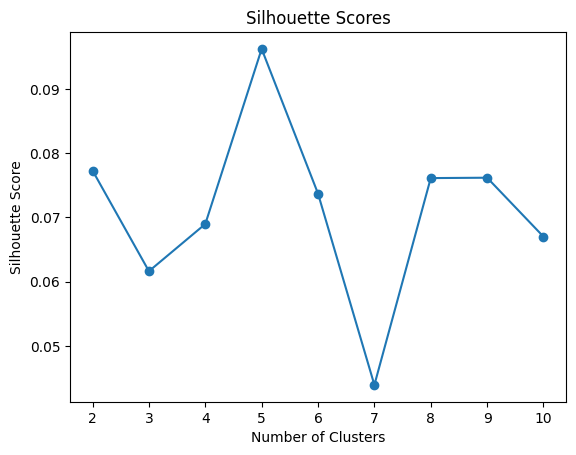

In [31]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow Method
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features.drop(columns=['CustomerID']))
    inertia.append(kmeans.inertia_)

    # Calculate and append the silhouette score only once
    score = silhouette_score(scaled_features.drop(columns=['CustomerID']), kmeans.labels_)
    silhouette_scores.append(score)

# Print the silhouette scores for each k
for k, score in zip(range(2, 11), silhouette_scores):
    print(f"Silhouette score for k={k}: {score:.3f}")

# Plot Elbow Method
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette Scores
plt.plot(range(2, 11), silhouette_scores, marker='o')  # Now silhouette_scores has the correct length
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

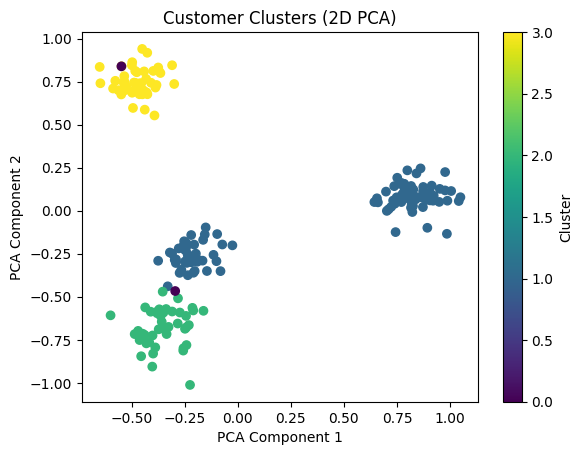

In [23]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features.drop(columns=['CustomerID']))

# Plot clusters
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Clusters (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [25]:
# Select only numeric columns for calculating the mean
numeric_features = customer_features.select_dtypes(include=['number'])

# Group by 'Cluster' and calculate the mean for numeric features
cluster_profiles = numeric_features.groupby('Cluster').mean()
print(cluster_profiles)

          TotalSpend  NumTransactions  AvgTransactionValue      P001  \
Cluster                                                                
0        5460.760000         8.000000           687.267778  0.000000   
1        3606.092524         5.067961           704.615446  0.029126   
2        3272.018889         5.266667           638.074558  0.044444   
3        3273.584898         4.591837           697.248462  0.061224   

             P002      P003      P004      P005      P006      P007  ...  \
Cluster                                                              ...   
0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
1        0.058252  0.067961  0.038835  0.038835  0.048544  0.038835  ...   
2        0.044444  0.044444  0.044444  0.044444  0.022222  0.066667  ...   
3        0.000000  0.061224  0.020408  0.040816  0.142857  0.020408  ...   

             P092      P093      P094      P095      P096      P097      P098  \
Cluster                      